# Analyse input variables of ISMIP files


In [1]:
import os
import rioxarray as rioxr
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob
import rasterio as rio

import pandas as pd 

import seaborn as sns

# Import user functions
import nbFunctions as myf 

# homedir = '/Users/.../Documents/'
homedir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'
homedir = '/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'

In [2]:
from cycler import cycler

# my_palette = sns.color_palette("blend:#7AB,#EDA")
my_palette = sns.color_palette('crest',5) # can access i'th color by indexing
my_palette
# sns.color_palette('crest',5, as_cmap=True)

# class_palette = sns.color_palette("Set2",5 ).as_hex()
class_palette = sns.color_palette().as_hex()[:5]
class_palette[0]

model_cmap_list = []
for class_color in class_palette:
    class_clist = sns.color_palette("light:"+class_color,3) + sns.color_palette("dark:"+class_color+'_r',3)[1:] 
    model_cmap_list.append(class_clist)
    
# sns.color_palette("dark:"+class_palette[0])

my_palette
my_palette2 = ['salmon']+ my_palette
my_palette2


# plt.rcParams.update({'font.size': 16})
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load shapefiles for mask

In [5]:

homedir = '/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'
import os
import geopandas as gpd 

''' --------------
Get Shapefiles 
------------------ '''
# geojson
gridTiles_geojson_path = os.path.join(homedir,'Data/tiles/gridTiles_iceShelves_EPSG3031.geojson')
gridTiles = gpd.read_file(gridTiles_geojson_path)

# measures ice shelves
iceshelf_path_meas = os.path.join(homedir, 'QGis/Quantarctica/Quantarctica3/Glaciology/MEaSUREs Antarctic Boundaries/IceShelf/IceShelf_Antarctica_v02.shp')
iceshelf_poly_meas = gpd.read_file(iceshelf_path_meas)
iceshelf_polygon_gpd = iceshelf_poly_meas

# measures grounding line
gl_path_meas = os.path.join(homedir, 'QGis/Quantarctica/Quantarctica3/Glaciology/MEaSUREs Antarctic Boundaries/GroundingLine_Antarctica_v2.shp')
groundingLine_gpd = gpd.read_file(gl_path_meas)


# ## SECTORS for AIS
roi_path = os.path.join(homedir, 'QGis/data_NeRD/AIS_outline_sectors.shp')
roi_poly = gpd.read_file(roi_path)
region_ID_list = roi_poly['sector_ID'].to_list()


roi_poly

,sector_ID,sectorNAME,x_label,y_label,geometry
0,WS-b,None,NaN,NaN,"POLYGON ((-234790.440 1102885.003, -817199.621..."
1,WIS,West Indian,2500700.0,1980600.0,"POLYGON ((355417.402 2272581.101, 1130695.760 ..."
2,EIS,East Indian,2500700.0,-1700600.0,"POLYGON ((2742417.175 -38120.436, 2838893.457 ..."
3,RS,Ross Sea,-314500.0,-1700600.0,"POLYGON ((290784.599 -2038584.517, 222053.130 ..."
4,ASE,AmundsenSea,-2102000.0,-904500.0,"POLYGON ((-1904208.456 -569370.550, -1803318.2..."
5,BSE,Bellingshausen Sea,-2402000.0,402600.0,"POLYGON ((-1964742.593 -571892.806, -2021808.6..."
6,WS-a,None,NaN,NaN,"POLYGON ((-2492209.324 1662825.777, -1263071.7..."
7,WS,Weddell Sea,-1234600.0,1980600.0,"POLYGON ((-2492209.324 1662825.777, -398737.06..."
8,WIS-a,None,NaN,NaN,"POLYGON ((394873.008 1932501.069, 355115.499 2..."
9,WIS-b,None,NaN,NaN,"POLYGON ((1645238.677 974426.374, 2421867.283 ..."


# Data load functions

In [6]:

def load_ismip_experiment(file, velocity_varnames=('xvelsurf','yvelsurf') ):
    varname = os.path.basename(file).split('_')[0]
    var_name_vx, var_name_vy = velocity_varnames

    data_ismip_ds = xr.open_dataset(file, decode_times=False)
    
    ## Get number of days from calendar
    # TO DO: The proleptic_gregorian calander (used by NCAR CISM) includes leap days. 
    # The nubmer of days is used to convert velocity m/s to m/yr, so here it's assumed that using 365 days for all years is an appropriate simplification
    # model_calendar = data_ismip_ds['time'].attrs['calendar'] # 365_day
    try:
        model_calendar = data_ismip_ds.time.attrs['calendar'] 
    except KeyError:
        # print('.. Did not find property ''calendar'' in attributes. Assume 365-day calendar')
        # print('.. Available attributes: ', data_ismip_ds.time.attrs)
        model_calendar = '365_day_assumed'
    if model_calendar == 'proleptic_gregorian':
        # print('.. Data uses proleptic gregorian calander, which includues leap days. Simplify to 365 days for velocity unit conversion.')
        model_calendar = '365_day_as_simplified_proleptic_gregorian'

    ndays = int(model_calendar.split('_day')[0]) # 365


    ## Drop irrelevant variables (e.g. 'time_bnds' in AWI_PISM and 'lon_bnds','lat_bnds' in NCAR_CISM) 
    # data_ismip_ds = data_ismip_ds.drop('time_bnds')
    data_ismip_ds = data_ismip_ds[varname]

    if 'JPL1' in file:
        # print(data_ismip_ds)
        if varname == 'xvelmean': #  or varname == 'xvelsurf':
            # Also fix issue where xvelmean has a typo in its dimension; consisting of (ny,x) instead of (y,x) 
            if isinstance(data_ismip_ds, xr.Dataset):
                data_ismip_ds[varname] = data_ismip_ds[varname].rename({"ny": "y"})
            if isinstance(data_ismip_ds, xr.DataArray):
                data_ismip_ds = data_ismip_ds.rename({"ny":"y"})

        if varname == 'orog':
            ## Infer path to AWI_PISM model (use arbitrary variable/experiment number for this)
            path_parts = file.split('/')
            idx_ismip = path_parts.index('ISMIP6')
            # And issue where expirment ctrl_proj has no correct attritbutes (copy those of exp05)
            if 'CloudDoc' in file: # iCloud path
                tmp_path = '/'.join(path_parts[:idx_ismip]+['ISMIP6','MODELS', 'JPL1_ISSM'])
                file_tmp = glob.glob(os.path.join(tmp_path,'orog_AIS_JPL1_ISSM_exp05.nc') )[0]
            else: # local path
                tmp_path = '/'.join(path_parts[:idx_ismip]+['ISMIP6','JPL1_ISSM'])
                file_tmp = glob.glob(os.path.join(tmp_path,'orog_AIS_JPL1_ISSM_exp05.nc') )[0]

            with xr.open_dataset(file_tmp,  decode_times=False) as ds_tmp:
                data_ismip_ds.attrs = ds_tmp.attrs
    
    ## For JPL1 and NCAR, fix grid issues:
    if 'JPL1' in file or 'NCAR' in file:
        # print('JPL1/NCAR: copypaste coordinates from AWI_PISM to grid')
        
        ## Infer path to AWI_PISM model (use arbitrary variable/experiment number for this)
        path_parts = file.split('/')
        idx_ismip = path_parts.index('ISMIP6')
        if 'CloudDoc' in file: # iCloud path
                tmp_path = '/'.join(path_parts[:idx_ismip]+['ISMIP6','MODELS', 'AWI_PISM'])
                file_tmp = glob.glob(os.path.join(tmp_path,'orog_AIS_AWI_PISM1_exp05.nc') )[0]
        else: # local path
            tmp_path = '/'.join(path_parts[:idx_ismip]+['ISMIP6','AWI_PISM'])
            file_tmp = glob.glob(os.path.join(tmp_path,'orog_AIS_AWI_PISM1_exp05.nc') )[0]

        with xr.open_dataset(file_tmp,  decode_times=False) as ds_tmp:
            ## fill awi grid coordinates
            data_ismip_ds = data_ismip_ds.assign_coords(y=ds_tmp['y']) # for JPL1
            data_ismip_ds = data_ismip_ds.assign_coords(x=ds_tmp['x']) # for JPL1
            # print('.. Coords after fix: ',list(data_ismip_ds.coords) )
            # print('.. Resolution after fix: ',data_ismip_ds.rio.resolution()) 
            # print('.. Dimensions after fix: ',data_ismip_ds.dims) 

    if 'NCAR' in file and 'exp07' in file:
        ## Infer path to AWI_PISM model (use arbitrary variable/experiment number for this)
        path_parts = file.split('/')
        idx_ismip = path_parts.index('ISMIP6')
        # Error in time array of NCAR_CISM exp07 : copypaste the time array of exp05
        if 'CloudDoc' in file: # iCloud path
                tmp_path = '/'.join(path_parts[:idx_ismip]+['ISMIP6','MODELS', 'NCAR_CISM'])
                file_tmp = glob.glob(os.path.join(tmp_path,'orog_AIS_NCAR_CISM_exp05.nc') )[0]
        else: # local path
            tmp_path = '/'.join(path_parts[:idx_ismip]+['ISMIP6','NCAR_CISM'])
            file_tmp = glob.glob(os.path.join(tmp_path,'orog_AIS_NCAR_CISM_exp05.nc') )[0]
        with xr.open_dataset(file_tmp,  decode_times=False) as ds_tmp:
            data_ismip_ds['time'] = ds_tmp['time']
            data_ismip_ds.attrs = ds_tmp.attrs
    
    if 'NCAR' in file or 'ILTS_PIK_SICOPOLIS' in file:
        # drop latlon from dimensions
        data_ismip_ds = data_ismip_ds.drop(['lat','lon'])
        # print('..drop latlon')
    # print('..coords: ',list(data_ismip_ds.coords))

    ''' --------------
    Convert variables to correct units
    ISMIP data is in m/s; convert to m/yr (RF is trained on velocity from ITS_LIVE, which is m/yr)
    ------------------ '''
    if 'vel' in varname and isinstance(data_ismip_ds, xr.DataArray):
        # print('.. converting velocity unit')
        data_ismip_ds = data_ismip_ds*60 *60 *24 * ndays
        data_ismip_ds['units']='m/yr'

    if 'vel' in varname and isinstance(data_ismip_ds, xr.Dataset):
        vx_attrs = data_ismip_ds[var_name_vx].attrs
        vx_attrs['units']='m/yr'
        vy_attrs = data_ismip_ds[var_name_vy].attrs
        vy_attrs['units']='m/yr'
        data_ismip_ds[var_name_vx] = (data_ismip_ds[var_name_vx]*60 *60 *24 * ndays).assign_attrs(vx_attrs) # m/s to m/yr
        data_ismip_ds[var_name_vy] = (data_ismip_ds[var_name_vy]*60 *60 *24 * ndays).assign_attrs(vy_attrs) # m/s to m/yr


    ## CORRECT TIME LENGTHS (for ctrl experiment)
    data_ismip_ds = data_ismip_ds.isel(time=slice(0,86))
    # print('.. time length: ', data_ismip_ds.time.size ) 
    
    ## set crs
    data_ismip_ds.rio.write_crs(3031,inplace=True)

    return data_ismip_ds
    


#### Set up dummy AIS grid for observations

In [7]:
## Make regular grid 
ais_dummy = myf.make_ais_grid(8e3)

In [8]:
# 

In [9]:
## Clip data to ice shelves, aggregate values
def sum_var_ds_year(var_ds, data_mask_gpd, normalise_px=True):

    ''' -------
    Clip to mask (e.g. Grounding line)
    ------------'''
    var_ds_mask  = var_ds.rio.clip( data_mask_gpd.geometry, data_mask_gpd.crs, drop=False, invert=True)
    # dmg_ds_mask.isel(time=3)[exp_var].plot.imshow()

    ''' -------
    - Aggregate to 1D 
    - Drop NaN
    ------------'''
    var_ds_stack = var_ds_mask.stack(samples=['x','y']) # (time, samples)
    # valid_px_t = dmg_ds_1d.count(dim='samples')[exp_var].values 
    var_ds_stack  = var_ds_stack.dropna(dim='samples',how='all') # only drop samples where all time-steps have NaN value (i.e. the mask)
    valid_px_t = var_ds_stack.count(dim='samples') # [exp_var].values # array of valid pxs per timestep

    ''' -------
    Sum damage values per year 
    - normalise for #pixels, as some ISMIP models allow for changing ice front but others not
    ------------'''

    if normalise_px: 
        ## sum per year, divided by #px per year
        # var_ds_sum_yr = var_ds_stack.sum(dim='samples' ) / valid_px_t # (time: 86)
        var_ds_sum_yr = var_ds_stack.mean(dim='samples' )# (time: 86) # time series of spatial mean
    else: 
        ## sum per year
        var_ds_sum_yr = var_ds_stack.sum(dim='samples' ) # (time: 86)

    return var_ds_sum_yr


# Load data using open_mfdataset per ismip model

In [10]:

path2ismip = os.path.join(os.path.expanduser('~'),'Documents/Data/ISMIP6/')
path2ismip = os.path.join(homedir,'Data/ISMIP6/MODELS/')

model_options = ['AWI_PISM','DOE_MALI','ILTS_PIK_SICOPOLIS', 'JPL1_ISSM', 'NCAR_CISM']

### Select variable to load

# varname = 'orog'
# varname = 'xvelsurf'
# varname = 'yvelsurf'
# varname = 'deltaV'


varname = 'orog'
# varname = 'v'
# varname = 'strain'

## Load all datasets (multi experiment) to a list

data_ismip_ds_list=[]
for ismip_model in model_options:
    print(ismip_model)

    ## Get files to load
    var_filelist = glob.glob( os.path.join(path2ismip,ismip_model,varname+'*.nc')  )
    
    if varname == 'deltaV' or varname == 'v' or varname=='strain':
        varname_tmp = '*vel' # both xvelocity and yvelocity
        var_filelist = glob.glob( os.path.join(path2ismip,ismip_model,varname_tmp+'*.nc')  )
    
    if 'JPL' in ismip_model and 'vel' in varname: #('vel' in varname or 'vel' in varname_tmp):
        print('processing JPL velo')
        varname_tmp = varname.replace('surf','mean')
        var_filelist = glob.glob( os.path.join(path2ismip,ismip_model,varname_tmp+'*.nc')  )
    # print(var_filelist)

    if len(var_filelist) < 5 and len(var_filelist) != 10 :
        raise ValueError('Did not find all experimentt files. Avail files ({}):\n {}'.format( len(var_filelist) , var_filelist))
        
    var_filelist.sort()

    ## Load all experiments to a list of datasets
    data_ismip_exp_list = []
    for file in var_filelist:
         # extract exp_num from filename
        exp_num = file.split('.')[0][-5:]
        if not exp_num.startswith('exp'):
            exp_num = 'ctrl'
        new_var_name = varname + '_'+exp_num

        if varname == 'deltaV' or varname == 'v' or varname == 'strain':
            varname_tmp = os.path.basename(file).split('_')[0] # get xvelsurf or xvelmean
            new_var_name = varname_tmp + '_'+exp_num
        
        print(file) 
        
        # 'model_abbrev': ismip_model,
        ismip_model = file.split('/')[-2]
        
        ## load netCDF, fix some issues per model
        data_ismip_da = load_ismip_experiment(file)# , velocity_varnames=('xvelsurf','yvelsurf') )
        
        data_ismip_exp_list.append( data_ismip_da.to_dataset(name=new_var_name) )
    
    # combine all experiments of 1 model
    data_ismip_ds = xr.merge(data_ismip_exp_list)

    ## Fix CISM/SICOPOLIS lat/lon shittoe
    # for idx, var_ds in enumerate(dmg_ds_list):
    #     ismip_model = var_ds.attrs['model_abbrev']
    #     print(ismip_model)
    # if 'CISM' in ismip_model or 'SICOPOLIS' in ismip_model:
    #     # drop latlon from dimensions
    #     data_ismip_ds = data_ismip_ds.drop(['lat','lon'])
    if 'SICOPOLIS' in ismip_model:
        data_ismip_ds.rio.write_crs(3031,inplace=True)
        try:
            data_ismip_ds = data_ismip_ds.rename({'crs':'spatial_ref'}) # .drop(['crs'])
        except:
            pass
        ## set crs
        data_ismip_ds.rio.write_crs(3031,inplace=True)
        # print(var_ds.coords)

    data_ismip_ds.attrs['model_abbrev']= ismip_model
    data_ismip_ds_list.append(data_ismip_ds)


data_ismip_ds


AWI_PISM
/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/ISMIP6/MODELS/AWI_PISM/orog_AIS_AWI_PISM1_ctrl_proj_std.nc
/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/ISMIP6/MODELS/AWI_PISM/orog_AIS_AWI_PISM1_exp05.nc
/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/ISMIP6/MODELS/AWI_PISM/orog_AIS_AWI_PISM1_exp06.nc
/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/ISMIP6/MODELS/AWI_PISM/orog_AIS_AWI_PISM1_exp07.nc
/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/ISMIP6/MODELS/AWI_PISM/orog_AIS_AWI_PISM1_exp08.nc
DOE_MALI
/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/ISMIP6/MODELS/DOE_MALI/orog_AIS_DOE_MALI_ctrl_proj_std.nc
/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Do

/var/folders/z0/y87v8g896kz8s6kfxd4mzt700000gn/T/ipykernel_91839/79695748.py:91: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  data_ismip_ds = data_ismip_ds.drop(['lat','lon'])
/var/folders/z0/y87v8g896kz8s6kfxd4mzt700000gn/T/ipykernel_91839/79695748.py:91: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  data_ismip_ds = data_ismip_ds.drop(['lat','lon'])


/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/ISMIP6/MODELS/JPL1_ISSM/orog_AIS_JPL1_ISSM_exp06.nc
/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/ISMIP6/MODELS/JPL1_ISSM/orog_AIS_JPL1_ISSM_exp07.nc
/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/ISMIP6/MODELS/JPL1_ISSM/orog_AIS_JPL1_ISSM_exp08.nc
NCAR_CISM
/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/ISMIP6/MODELS/NCAR_CISM/orog_AIS_NCAR_CISM_ctrl_proj_std.nc
/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/ISMIP6/MODELS/NCAR_CISM/orog_AIS_NCAR_CISM_exp05.nc
/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/ISMIP6/MODELS/NCAR_CISM/orog_AIS_NCAR_CISM_exp06.nc
/Users/mizeboud/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents -

<xarray.Dataset> Size: 996MB
Dimensions:      (time: 86, y: 761, x: 761)
Coordinates:
  * time         (time) float32 344B 7.3e+03 7.665e+03 ... 3.796e+04 3.832e+04
  * y            (y) float64 6kB -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * x            (x) float64 6kB -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
    spatial_ref  int64 8B 0
Data variables:
    orog_ctrl    (time, y, x) float32 199MB ...
    orog_exp05   (time, y, x) float32 199MB ...
    orog_exp06   (time, y, x) float32 199MB ...
    orog_exp07   (time, y, x) float32 199MB ...
    orog_exp08   (time, y, x) float32 199MB ...
Attributes:
    model_abbrev:  NCAR_CISM

In [11]:

len(data_ismip_ds_list)
for tmp in data_ismip_ds_list:
    print(tmp.model_abbrev)

AWI_PISM
DOE_MALI
ILTS_PIK_SICOPOLIS
JPL1_ISSM
NCAR_CISM


In [12]:
if varname == 'deltaV' or varname == 'v' or varname=='strain': ## calculate additionala features based on x/y velocity
    data_ismip_strain_list=[]
    for idx, data_ismip_ds in enumerate(data_ismip_ds_list): ## ONLY RUN PART OF MODELS
        print(data_ismip_ds.attrs['model_abbrev'])
        var_list = list(data_ismip_ds.data_vars)# [0].split('_')[0]
        var_vx_list = [var for var in var_list if 'xvel' in var]
        
        data_ismip_var_list = []
        for var_vx in var_vx_list: # loops all experiments
            var_vy = 'y'+var_vx[1:] # get corresponding yvelsurf or yvelmean
            exp_num = var_vx.split('_')[-1] # e.g. exp05

            if varname == 'deltaV': # calculate temporal velocity

                # calculate strain components and temporal features
                _, exp_var_ds = myf.calculate_velo_strain_features(data_ismip_ds, velocity_names=(var_vx,var_vy), length_scales=['1px'])
                
                exp_var_ds = exp_var_dt.rename({'dEmax_1px':'deltaE_'+exp_num, 'deltaV':'deltaV_'+exp_num})
                # print(list(exp_var_dt.data_vars))

            elif varname == 'v': # calculate velocity magnitude

                 # Calculate Velocity
                data_da_v = ((data_ismip_ds[var_vx]**2 + data_ismip_ds[var_vy]**2)**0.5) 
                exp_var_ds = data_da_v.to_dataset(name='v_'+exp_num) # dataset wiht only velocity
                exp_var_ds.attrs['model_abbrev'] = data_ismip_ds.attrs['model_abbrev']
            
            elif varname == 'strain': ## calculate strain components
                exp_var_strain, _ = myf.calculate_velo_strain_features(data_ismip_ds, velocity_names=(var_vx,var_vy), length_scales=['1px'])
                exp_var_ds = exp_var_strain[['emax_1px','elon_1px','eshear_1px','etrans_1px']]
                exp_var_ds = exp_var_ds.rename_vars({'emax_1px':'emax_'+exp_num, 
                                            'elon_1px':'elon_'+exp_num,
                                            'eshear_1px':'eshear_'+exp_num,
                                            'etrans_1px':'etrans_'+exp_num,})
                exp_var_ds.attrs['model_abbrev'] = data_ismip_ds.attrs['model_abbrev']
                
            # data_ismip_ds = xr.merge([data_ismip_ds, exp_var_ds]) # append to one big dataset
            data_ismip_var_list.append( exp_var_ds)  # only keep deltaV or V values

        data_ismip_var = xr.merge(data_ismip_var_list)
        # # put in list
        # data_ismip_ds_list[idx] = data_ismip_ds
        data_ismip_strain_list.append(data_ismip_var)
    
    ## overwrite loaded datalist with calculated variables
    # data_ismip_ds_list = data_ismip_strain_list.copy()
    # varname= 'dV' # set to dV hehe

# data_ismip_var
# data_ismip_strain_list[0]

#### plot maps at 2100

In [13]:
# data_ismip_strain_list[0]['elon_exp05'].isel(time=10).plot.imshow(vmin=-0.01,vmax=0.01,cmap='RdBu')

In [14]:

changeType = 'pctChange'
changeType = 'absoluteChange'

In [15]:
# data_ismip_ds

strain_var = 'emax'
strain_var = 'orog'
# vbounds =0.005
# if varname=='strain': 
if varname == 'deltaV' or varname == 'v' or varname=='strain':
    ## Make ISMIP projections relative to CTRL of each own model
    data_absChange_2100_list =[]
    data_pctChange_2100_list =[]
    for dmg_ds in data_ismip_strain_list:#[data_ismip_var] : # .data_vars:
        ## First temporal rolling mean
        dmg_ds = dmg_ds.isel(time=slice(-10,-1) ).rolling(time=5, min_periods=1).mean() # smooth ; (time, model)

        ## Then calcualte Absolute change wrt CTRL 
        if varname == 'strain':
            experiment_list = list(dmg_ds.data_vars)
            data_ds_wrtCTRL_strainlist = []
            for strain_var in ['emax','elon','eshear','etrans']:
                ## select strain component
                var_explist = [var for var in experiment_list if strain_var in var]
                tmp_ds = dmg_ds[var_explist] 
                tmp_ds = abs(tmp_ds) ## make sure its the strain magnitude 
                data_ds_wrtCTRL_strainvar = (tmp_ds-  tmp_ds[strain_var+'_ctrl'] ) 
                if changeType == 'pctChange':
                    print('..calculating pct Change')
                    data_ds_wrtCTRL_strainvar = data_ds_wrtCTRL_strainvar / tmp_ds[strain_var+'_ctrl']  * 100  # (exp_da - exp_ctrl)  / exp_ctrl * 100
                data_ds_wrtCTRL_strainlist.append(data_ds_wrtCTRL_strainvar)
            data_ds_wrtCTRL = xr.merge(data_ds_wrtCTRL_strainlist)
        else:
            data_ds_wrtCTRL = (dmg_ds-  dmg_ds[varname+'_ctrl'] ) 


        model_data = data_ds_wrtCTRL.isel(time=-1).drop('time').rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)
        model_data.attrs['model_abbrev']=dmg_ds.model_abbrev
        if changeType == 'pctChange':
            data_pctChange_2100_list.append(model_data)
        elif changeType == 'absoluteChange':
            data_absChange_2100_list.append(model_data )
        
   
else: 
    # strain_var=varname
    # # if varname=='orog': 
    ## Make ISMIP projections relative to CTRL of each own model
    data_absChange_2100_list =[] 
    for dmg_ds in data_ismip_ds_list: # [data_ismip_ds] : # .data_vars:
        print(dmg_ds.model_abbrev)
        ## First temporal rolling mean
        dmg_ds = dmg_ds.isel(time=slice(-10,-1) ).rolling(time=5, min_periods=1).mean() # smooth ; (time, model)

        ## Then calcualte change wrt CTRL 
        data_ds_wrtCTRL = (dmg_ds-  dmg_ds[varname+'_ctrl'] ) 

        model_data = data_ds_wrtCTRL.isel(time=-1).drop('time').rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)
        model_data.attrs['model_abbrev']=dmg_ds.model_abbrev
        data_absChange_2100_list.append(model_data) # data_ds_wrtCTRL.isel(time=-1).drop('time') )
        
len(data_absChange_2100_list)
# data_absChange_2100_list[0]

AWI_PISM


/var/folders/z0/y87v8g896kz8s6kfxd4mzt700000gn/T/ipykernel_91839/3076599541.py:78: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  model_data = data_ds_wrtCTRL.isel(time=-1).drop('time').rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)


DOE_MALI


/var/folders/z0/y87v8g896kz8s6kfxd4mzt700000gn/T/ipykernel_91839/3076599541.py:78: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  model_data = data_ds_wrtCTRL.isel(time=-1).drop('time').rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)


ILTS_PIK_SICOPOLIS


/var/folders/z0/y87v8g896kz8s6kfxd4mzt700000gn/T/ipykernel_91839/3076599541.py:78: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  model_data = data_ds_wrtCTRL.isel(time=-1).drop('time').rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)


JPL1_ISSM


/var/folders/z0/y87v8g896kz8s6kfxd4mzt700000gn/T/ipykernel_91839/3076599541.py:78: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  model_data = data_ds_wrtCTRL.isel(time=-1).drop('time').rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)


NCAR_CISM


/var/folders/z0/y87v8g896kz8s6kfxd4mzt700000gn/T/ipykernel_91839/3076599541.py:78: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  model_data = data_ds_wrtCTRL.isel(time=-1).drop('time').rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)


5

In [16]:
# dmg_ds
# dmg_change_2100_list[0]
# data_absChange_2100_list

In [17]:

''' ------------------------
### COMBINING SCENARIOS 
------------------------ '''
import dask
with dask.config.set(**{'array.slicing.split_large_chunks': True}):

    # concatenate all models per separate forcing sceenario
    # Only combine last time slice (as time array values are not generalised across models, concatenation would go amiss otherwise)

    if changeType == 'absoluteChange':
        dmg_change_2100_list = data_absChange_2100_list # absolute change
        attr_descript = 'Model Ensemble of dmg-absolute-change wrt ctrl at 2100'
    elif changeType == 'pctChange':
        dmg_change_2100_list = data_pctChange_2100_list # percentual change
        attr_descript = 'Model Ensemble of dmg-percent-change wrt ctrl at 2100'

    # RCP26_dmg_ds = xr.concat( [dmg_ds[['D_exp07']] for dmg_ds in dmg_change_2100_list], dim='model_dim' )
    # RCP85_dmg_ds = xr.concat( [dmg_ds[['D_exp05','D_exp06','D_exp08']] for dmg_ds in dmg_change_2100_list], dim='model_dim' )

    MODELS_var_ds = xr.concat( [dmg_ds[list(dmg_change_2100_list[0].data_vars)] for dmg_ds in dmg_change_2100_list], dim='model_dim' )
    MODELS_var_ds.attrs['description'] = attr_descript
MODELS_var_ds




<xarray.Dataset> Size: 58MB
Dimensions:      (model_dim: 5, y: 761, x: 761)
Coordinates:
  * x            (x) float64 6kB -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * y            (y) float64 6kB -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
    spatial_ref  int64 8B 0
    crs          int64 8B 0
Dimensions without coordinates: model_dim
Data variables:
    orog_ctrl    (model_dim, y, x) float32 12MB nan nan nan nan ... 0.0 0.0 0.0
    orog_exp05   (model_dim, y, x) float32 12MB nan nan nan nan ... 0.0 0.0 0.0
    orog_exp06   (model_dim, y, x) float32 12MB nan nan nan nan ... 0.0 0.0 0.0
    orog_exp07   (model_dim, y, x) float32 12MB nan nan nan nan ... 0.0 0.0 0.0
    orog_exp08   (model_dim, y, x) float32 12MB nan nan nan nan ... 0.0 0.0 0.0
Attributes:
    model_abbrev:  AWI_PISM
    description:   Model Ensemble of dmg-absolute-change wrt ctrl at 2100

In [18]:
experiment_list = [var for var in list(MODELS_var_ds.data_vars) if 'ctrl' not in var]
experiment_list

['orog_exp05', 'orog_exp06', 'orog_exp07', 'orog_exp08']

pctile bounds -15.590384 -6.032442


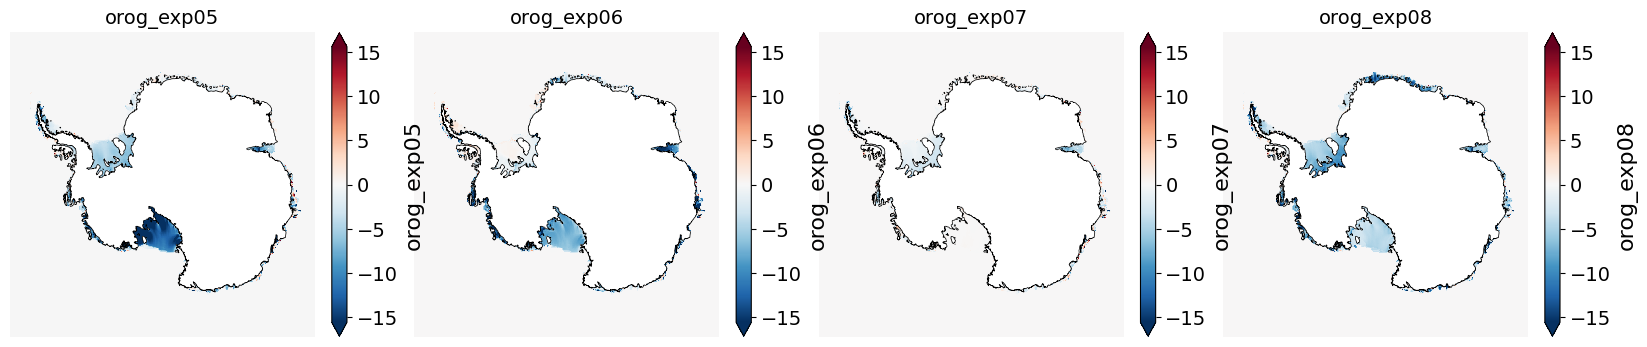

In [19]:
experiment_list = [var for var in list(MODELS_var_ds.data_vars) if 'ctrl' not in var]

''' process single variable '''

if varname != 'strain':


    data_mask = xr.where( np.isnan(MODELS_var_ds), 0, 1).sum(dim='model_dim')[varname+'_exp05']#['D_exp05']# .plot.imshow()
    # data_mask
    MODELS_var_ds

    ## determine visualisation bounds: percentile
    dd_min = np.nanpercentile( MODELS_var_ds.to_array('exp_dim').mean(dim=['model_dim','exp_dim']).where(data_mask>=2).rio.clip(
        groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True
        ) , 0.05) 
    dd_max = np.nanpercentile(MODELS_var_ds.to_array('exp_dim').mean(dim=['model_dim','exp_dim']).where(data_mask>=2).rio.clip(
        groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True
        ), 0.95) 

    vbounds = np.max([np.abs(dd_min), np.abs(dd_max)])
    print('pctile bounds', dd_min, dd_max)


    # fig,axs=plt.subplots(2,2, figsize=(20,20)) 
    fig,axs=plt.subplots(1,4, figsize=(20,20)) 
    r=0;c=0
    for exp_var in experiment_list: # ['D_exp05','D_exp06','D_exp07','D_exp08']:

        ax=axs[c] # [r,c]
        ## ensemble mean

        MODELS_var_ds[exp_var].mean(dim='model_dim').where(data_mask>=2).plot.imshow(ax=ax, vmin=-vbounds,vmax=vbounds, 
                                cmap='RdBu_r',  cbar_kwargs={'fraction':0.045}
                                )
        ax.set_title('Ensamble mean dmg change@2100, ' + exp_var)
        figname = 'input2100_ensembleMean' + '_'+changeType+'_wrtCTRL_'+ 'experiments' + '_'+ varname + '.png'

        ## Plot grounding line
        # iceshelf_polygon_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')
        groundingLine_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')
                                
        ax.set_aspect('equal')
        ax.set_axis_off()
        ax.set_title(exp_var)

        # ax.set_title()
        c+=1
        # if c>1:
        #     c=0
        #     r+=1

    # print('..saving ', figname)
    # fig.tight_layout()
    # fig.savefig(os.path.join(homedir,'Data/ISMIP6/figures/maps/',figname), bbox_inches='tight')

elif varname == 'strain':

    for strain_var in ['emax','elon','eshear','etrans']:
        print('--',strain_var)
        ## select strain component
        var_explist = [var for var in experiment_list if strain_var in var]
        MODELS_selectvar_ds = MODELS_var_ds[var_explist]

        # data_mask     
        data_mask = xr.where( np.isnan(MODELS_selectvar_ds), 0, 1).sum(dim='model_dim')[strain_var+'_exp05']
        

        ## determine visualisation bounds: percentile
        if changeType == 'pctChange':
            dd_min = np.nanpercentile( MODELS_selectvar_ds.to_array('exp_dim').mean(dim=['model_dim','exp_dim']).where(data_mask>=2).rio.clip(
                groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True
                ) , 0.05)#0.15; 0.05) 
            dd_max = np.nanpercentile(MODELS_selectvar_ds.to_array('exp_dim').mean(dim=['model_dim','exp_dim']).where(data_mask>=2).rio.clip(
                groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True
                ), 0.95)#0.85; 0.95) 
        elif changeType == 'absoluteChange':
            if strain_var == 'emax':
                dd_min = -0.002; dd_max = 0.002
            else:
                dd_min = -0.002; dd_max = 0.002

        vbounds = np.max([np.abs(dd_min), np.abs(dd_max)])
        print('vis bounds', dd_min, dd_max)


        # fig,axs=plt.subplots(2,2, figsize=(20,20)) 
        fig,axs=plt.subplots(1,4, figsize=(20,20)) 
        r=0;c=0
        for exp_var in var_explist: # ['D_exp05','D_exp06','D_exp07','D_exp08']:

            ax=axs[c] # [r,c]
            ## ensemble mean

            MODELS_selectvar_ds[exp_var].mean(dim='model_dim').where(data_mask>=2).plot.imshow(ax=ax, vmin=-vbounds,vmax=vbounds, 
                                    cmap='RdBu_r',  cbar_kwargs={'fraction':0.045}
                                    )
            ax.set_title('Ensamble mean dmg change@2100, ' + exp_var)
            figname = 'input2100_ensembleMean' + '_'+changeType+'_wrtCTRL_'+ 'experiments' + '_'+ strain_var + '.png'

            ## Plot grounding line
            # iceshelf_polygon_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')
            groundingLine_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')
                                    
            ax.set_aspect('equal')
            ax.set_axis_off()
            ax.set_title(exp_var)

            # ax.set_title()
            c+=1
            # if c>1:
            #     c=0
            #     r+=1

        # print('..saving ', figname)
        # fig.tight_layout()
        # fig.savefig(os.path.join(homedir,'Data/ISMIP6/figures/maps/',figname), bbox_inches='tight')



In [22]:

# ## assume same year values for all experiments
years = np.arange(2015,2101)
years

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,
       2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058,
       2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069,
       2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080,
       2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091,
       2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100])

# Plot variable evolution wrt CTRL

## Plot regional percentchange at 2100 - barplot

In [28]:
# 

In [24]:
# region_ID_list
# data_ismip_ds_list[0] # (time,x,y) (86,xx,yy); all experiment as variable
# data_absChange_2100_list[0] # (y,x) ; all experiment as variable
dmg_change_2100_list[0]

<xarray.Dataset> Size: 12MB
Dimensions:      (x: 761, y: 761)
Coordinates:
  * x            (x) float64 6kB -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
  * y            (y) float64 6kB -3.04e+06 -3.032e+06 ... 3.032e+06 3.04e+06
    spatial_ref  int64 8B 0
Data variables:
    orog_ctrl    (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    orog_exp05   (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    orog_exp06   (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    orog_exp07   (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    orog_exp08   (y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    model_abbrev:  AWI_PISM

In [25]:
'''## Calculate regional values '''
sector_ID_list = ['ASE','BSE','EIS','RS','WIS','WS']
ensemble_t2100_list=[]
for region_ID in sector_ID_list:
    print('-- REGION: ', region_ID)

    ## Select region
    region_gpd = roi_poly.loc[roi_poly['sector_ID'] == region_ID]
    region_name = region_gpd['sectorNAME'].values[0] 

    '''## Get ensemble'''
    k=0
    model_ds_1d_list = []

    # for model_idx , var_ds in enumerate(data_ismip_ds_list): ## uses all years
    for model_idx , var_ds in enumerate(dmg_change_2100_list): # data_absChange_2100_list): ## directly uses change at 2100
        
        ismip_model = var_ds.attrs['model_abbrev']
        # print(ismip_model)

        ## Overwrite temporal value with the same time array for all ismip_models'''
        # var_ds = var_ds.assign_coords(time=years) # annual values
        
        ## Clip to mask (e.g. Grounding line)
        var_ds  = var_ds.rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)
        
        ## CLIP TO SELECTED REGION
        var_ds  = var_ds.rio.clip( region_gpd.geometry, region_gpd.crs, drop=False, invert=False)

        ## Aggergate: Stack samples to 1D 
        # var_ds_stack = var_ds.isel(time=yidx).stack(samples=['x','y']) # select one year
        var_ds_stack = var_ds.stack(samples=['x','y']) 

        ## fill INF with NaN
        var_ds_stack = var_ds_stack.where(~np.isinf(var_ds_stack), np.nan)

        # Calculate Spatial average
        # var_exp_1d = var_ds_stack.mean(dim='samples') # time series of spatial mean; if input is (time,x,y) dataset
        var_exp_1d = var_ds_stack.mean(dim='samples',skipna=True) # single value at 2100; if input is (y,x) change at 2100 dataset

        # stack to list
        model_ds_1d_list.append(var_exp_1d)
    
    # single DA for all models; current region
    model_region_ensemble = xr.concat(model_ds_1d_list,dim='ismip_model') # (time, newDim)
    region_ensemble_t2100 = model_region_ensemble.to_array('experiment').to_dataset(name=region_ID)


    ''' Get ensemble '''
    ## depracated as I now directly use dataset of change-at-2100
    # exp_ctrl = model_region_ensemble[var_ctrl] #.isel(time=slice(1,86))# drop t=0 as it has only nan; dataArray (model, time)
    # model_region_ensemble_pct = ( model_region_ensemble.drop([var_ctrl]) - exp_ctrl )  / exp_ctrl * 100 # dataset minus dataArray
    # model_region_ensemble_pct = model_region_ensemble_pct.rolling(time=5, min_periods=1).mean() # smooth ; (time, model)

    # COnvert dataset with multivar to dataset with single var (experiment, model) 
    # where each model has 1 single value per experiment (i.e the %-change at 2100)
    # region_ensemble_t2100 = model_region_ensemble_pct.isel(time=-1).to_array('experiment').to_dataset(name=region_ID)

    ensemble_t2100_list.append( region_ensemble_t2100 ) # list of dataArrays

ensemble_t2100_list
regional_pct_ds = xr.merge( ensemble_t2100_list) # dataste
regional_pct_ds

# load into memory
# regional_pct_ds.load() 

# regional_pct_ds

-- REGION:  ASE
-- REGION:  BSE
-- REGION:  EIS
-- REGION:  RS
-- REGION:  WIS
-- REGION:  WS


<xarray.Dataset> Size: 656B
Dimensions:      (experiment: 5, ismip_model: 5)
Coordinates:
    spatial_ref  int64 8B 0
    crs          int64 8B 0
  * experiment   (experiment) object 40B 'orog_ctrl' ... 'orog_exp08'
Dimensions without coordinates: ismip_model
Data variables:
    ASE          (experiment, ismip_model) float32 100B 0.0 0.0 ... -3.947 -3.16
    BSE          (experiment, ismip_model) float32 100B 0.0 0.0 ... -0.3552
    EIS          (experiment, ismip_model) float32 100B 0.0 0.0 ... -0.4439
    RS           (experiment, ismip_model) float32 100B 0.0 0.0 ... -2.122
    WIS          (experiment, ismip_model) float32 100B 0.0 0.0 ... -0.6818
    WS           (experiment, ismip_model) float32 100B 0.0 0.0 ... -1.596

In [26]:
# convert to dataframe for barplot
# regional_pct_df = regional_pct_ds.to_dataframe()#.drop(['time','spatial_ref'],axis=1).reset_index() # 
regional_pct_df = regional_pct_ds.to_dataframe().drop(['spatial_ref'],axis=1).reset_index() # 
try:
    regional_pct_df = regional_pct_df.drop('crs',axis=1)
except:
    pass
regional_pct_df

,experiment,ismip_model,ASE,BSE,EIS,RS,WIS,WS
0,orog_ctrl,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,orog_ctrl,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,orog_ctrl,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,orog_ctrl,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,orog_ctrl,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,orog_exp05,0,-1.652923,-0.447825,-1.327143,-12.082748,-1.142289,-3.987705
6,orog_exp05,1,-16.402477,-5.299417,-6.967432,-11.671111,-0.843486,-3.309824
7,orog_exp05,2,-2.745853,-0.418578,-1.617109,-9.495227,-0.530706,-1.183819
8,orog_exp05,3,-4.280683,-1.067169,-7.661389,-13.149647,-3.305441,-3.091598
9,orog_exp05,4,-3.403169,-0.456559,-1.180139,-9.530224,-0.535623,-1.005045


In [28]:

# # Remove INF falues for pctChange

## replace with nan
regional_pct_df.replace([np.inf, -np.inf], np.nan, inplace=True)

orog


/var/folders/z0/y87v8g896kz8s6kfxd4mzt700000gn/T/ipykernel_91839/1740017364.py:87: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': '0.26'}` instead.

  bp = sns.barplot(data=df_long_both,  y='sector',x=plot_varname,
/var/folders/z0/y87v8g896kz8s6kfxd4mzt700000gn/T/ipykernel_91839/1740017364.py:87: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.9}` instead.

  bp = sns.barplot(data=df_long_both,  y='sector',x=plot_varname,


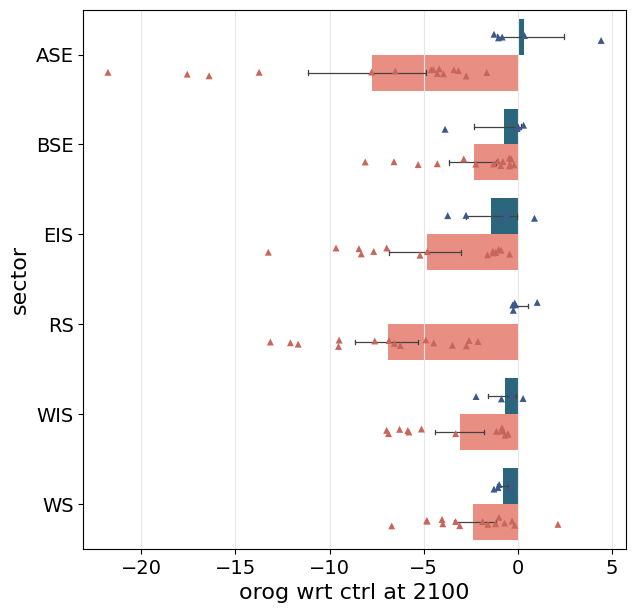

In [35]:

    
if varname == 'strain':
    for plot_varname in ['emax','elon','eshear','etrans']:
        print(plot_varname)
        var_explist = [plot_varname+'_exp05', plot_varname+'_exp06', plot_varname+'_exp08']
        # ## Split RCP scenarios
        regional_pct_df_RCP26 = regional_pct_df.loc[regional_pct_df['experiment']==plot_varname+'_exp07'].drop('ismip_model',axis=1)
        ## regional_pct_df_RCP85 = regional_pct_df.loc[regional_pct_df['experiment']!=plot_varname+'_exp07'].drop('ismip_model',axis=1)
        regional_pct_df_RCP85 = regional_pct_df.loc[regional_pct_df['experiment'].isin(var_explist)].drop('ismip_model',axis=1)
    
        try: 
            del df_long_RCP26
            del df_long_RCP85
        except:
            pass
            
        df_long_RCP26 = regional_pct_df_RCP26.melt(id_vars='experiment',value_vars=['ASE','BSE','EIS','RS','WIS','WS'],var_name='sector', value_name=plot_varname)
        df_long_RCP85 = regional_pct_df_RCP85.melt(id_vars='experiment',value_vars=['ASE','BSE','EIS','RS','WIS','WS'],var_name='sector', value_name=plot_varname)
        df_long_RCP26['scenario']='RCP2.6'
        df_long_RCP85['scenario']='RCP8.5'
        df_long_both = pd.concat([df_long_RCP26, df_long_RCP85]).reset_index()
        df_long_both
        df_long_both['sector'] = df_long_both['sector'].astype('category')
        df_long_both['sector_numeric'] = df_long_both['sector'].cat.codes
    
    
        '''## BAR AND STRIPPLOT'''
        fig,axs=plt.subplots(1,figsize=(7,7))
        ax=axs#[1]
        # bp = sns.barplot(data=df_long_both, x='sector',y=plot_varname, #  y='sector',x=varname,
        bp = sns.barplot(data=df_long_both,  y='sector',x=plot_varname,
                            ax=ax, hue='scenario',
                            palette=[my_palette2[-2],my_palette2[0]],
                            # orient='v', 
                            capsize=.1,errcolor='0.26',errwidth=0.9)
        # sp = sns.stripplot(data=df_long_both, x='sector',y=plot_varname,
        sp = sns.stripplot(data=df_long_both,  y='sector',x=plot_varname,
                            ax=ax, hue='scenario', 
                            jitter=True,dodge=True, marker='^', 
                            # orient='v',
                            palette=['#3c598a','#c8665b'], # 2 shades darker from salmon; 1 shades lighter from darkblue
                            edgecolor=None, legend=False,
                            )
    
        # ax.set_yticklabels(region_labels)#,rotation=90);#,ha='right');
        ax.set_xlabel( plot_varname + ' wrt ctrl at 2100'); #ax.set_ylabel('')
        # ax.legend(fontsize=14)
        # ax.set_xlim([-20,200])
        ax.get_legend().remove() # Remove the legend
        ax.xaxis.grid(True, color=[0.9 , 0.9, 0.9])
    
    
        # # # ### save fig
        # # # figname = 'dmg_barplot_percentChange2100_sectors_scenario_horiz.png'
        # # figname = 'barplot_'+changeType+'2100_sectors_scenario_vertical_'+plot_varname+'.png'
        # figname = 'barplot_'+changeType+'2100_sectors_scenario_horiz_'+plot_varname+'.png'
        # print(figname)
        # fig.savefig(os.path.join(homedir,'Data/ISMIP6/figures/aggregated_iceshelves/',figname), bbox_inches='tight')
else:
    plot_varname = varname 
    print(plot_varname)
    var_explist = [plot_varname+'_exp05', plot_varname+'_exp06', plot_varname+'_exp08']
    # ## Split RCP scenarios
    regional_pct_df_RCP26 = regional_pct_df.loc[regional_pct_df['experiment']==plot_varname+'_exp07'].drop('ismip_model',axis=1)
    ## regional_pct_df_RCP85 = regional_pct_df.loc[regional_pct_df['experiment']!=plot_varname+'_exp07'].drop('ismip_model',axis=1)
    regional_pct_df_RCP85 = regional_pct_df.loc[regional_pct_df['experiment'].isin(var_explist)].drop('ismip_model',axis=1)

    try: 
        del df_long_RCP26
        del df_long_RCP85
    except:
        pass
        
    df_long_RCP26 = regional_pct_df_RCP26.melt(id_vars='experiment',value_vars=['ASE','BSE','EIS','RS','WIS','WS'],var_name='sector', value_name=plot_varname)
    df_long_RCP85 = regional_pct_df_RCP85.melt(id_vars='experiment',value_vars=['ASE','BSE','EIS','RS','WIS','WS'],var_name='sector', value_name=plot_varname)
    df_long_RCP26['scenario']='RCP2.6'
    df_long_RCP85['scenario']='RCP8.5'
    df_long_both = pd.concat([df_long_RCP26, df_long_RCP85]).reset_index()
    df_long_both
    df_long_both['sector'] = df_long_both['sector'].astype('category')
    df_long_both['sector_numeric'] = df_long_both['sector'].cat.codes


    '''## BAR AND STRIPPLOT'''
    fig,axs=plt.subplots(1,figsize=(7,7))
    ax=axs#[1]
    # bp = sns.barplot(data=df_long_both, x='sector',y=plot_varname, #  y='sector',x=varname,
    bp = sns.barplot(data=df_long_both,  y='sector',x=plot_varname,
                        ax=ax, hue='scenario',
                        palette=[my_palette2[-2],my_palette2[0]],
                        # orient='v', 
                        capsize=.1,errcolor='0.26',errwidth=0.9)
    # sp = sns.stripplot(data=df_long_both, x='sector',y=plot_varname,
    sp = sns.stripplot(data=df_long_both,  y='sector',x=plot_varname,
                        ax=ax, hue='scenario', 
                        jitter=True,dodge=True, marker='^', 
                        # orient='v',
                        palette=['#3c598a','#c8665b'], # 2 shades darker from salmon; 1 shades lighter from darkblue
                        edgecolor=None, legend=False,
                        )

    # ax.set_yticklabels(region_labels)#,rotation=90);#,ha='right');
    ax.set_xlabel( plot_varname + ' wrt ctrl at 2100'); #ax.set_ylabel('')
    # ax.legend(fontsize=14)
    # ax.set_xlim([-20,200])
    ax.get_legend().remove() # Remove the legend
    ax.xaxis.grid(True, color=[0.9 , 0.9, 0.9])


### Calculate AIS avg values

In [30]:
'''## Calculate AIS values '''

'''## Get ensemble'''
k=0
model_ds_1d_list = []

# for model_idx , var_ds in enumerate(data_ismip_ds_list): ## uses all years
for model_idx , var_ds in enumerate(dmg_change_2100_list): # data_absChange_2100_list): ## directly uses change at 2100
    
    ismip_model = var_ds.attrs['model_abbrev']
    # print(ismip_model)

    ## Overwrite temporal value with the same time array for all ismip_models'''
    # var_ds = var_ds.assign_coords(time=years) # annual values
    
    ## Clip to mask (e.g. Grounding line)
    var_ds  = var_ds.rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)
    
#     ## Aggergate: Stack samples to 1D 
#     # var_ds_stack = var_ds.isel(time=yidx).stack(samples=['x','y']) # select one year
    var_ds_stack = var_ds.stack(samples=['x','y'])  # pctChange is (y,x) and has no time dimension anymore

    ## fill INF with NaN
    var_ds_stack = var_ds_stack.where(~np.isinf(var_ds_stack), np.nan)

    # Calculate Spatial average
    # var_exp_1d = var_ds_stack.mean(dim='samples') # time series of spatial mean; if input is (time,x,y) dataset
    var_exp_1d = var_ds_stack.mean(dim='samples', skipna=True) # single value at 2100; if input is (y,x) change at 2100 dataset
    # var_mean = var_ds_stack.mean(dim='samples')  # single mean value per model per experiment

    # stack to list
    model_ds_1d_list.append(var_exp_1d)

# # single DA for all models; current region
model_ais_ensemble = xr.concat(model_ds_1d_list,dim='ismip_model') # (time, newDim)
model_ais_ds = model_ais_ensemble.to_array('experiment').to_dataset(name='ais')
model_ais_ensemble
# model_ais_ds


<xarray.Dataset> Size: 116B
Dimensions:      (ismip_model: 5)
Coordinates:
    spatial_ref  int64 8B 0
    crs          int64 8B 0
Dimensions without coordinates: ismip_model
Data variables:
    orog_ctrl    (ismip_model) float32 20B 0.0 0.0 0.0 0.0 0.0
    orog_exp05   (ismip_model) float32 20B -5.391 -6.52 -0.5744 -6.582 -0.5488
    orog_exp06   (ismip_model) float32 20B -6.601 -3.87 -0.3623 -3.91 -0.3256
    orog_exp07   (ismip_model) float32 20B -0.3975 -0.4199 ... -0.9756 -0.09415
    orog_exp08   (ismip_model) float32 20B -6.379 -5.01 -0.409 -4.161 -0.3267

In [32]:
# model_ais_ensemble
if varname == 'strain':
    for plot_varname in ['emax','elon','eshear','etrans']:
        print(plot_varname)
        var_explist = [plot_varname+'_exp05', plot_varname+'_exp06',plot_varname+'_exp07', plot_varname+'_exp08']
        tmp_ds = model_ais_ensemble[var_explist].to_dataframe().drop(['spatial_ref'],axis=1).reset_index() # 
        if changeType == 'absoluteChange':
            # with pd.options.display.float_format = '{:.2e}'.format:
            with pd.option_context('display.float_format', '{:.2e}'.format):
                display(tmp_ds.describe().loc[['mean', 'min', 'max']].drop(['ismip_model'],axis=1) )
        else:
            display(tmp_ds.describe().loc[['mean', 'min', 'max']].drop(['ismip_model'],axis=1) )
    
else:
    plot_varname=varname
    print(plot_varname)
    var_explist = [plot_varname+'_exp05', plot_varname+'_exp06',plot_varname+'_exp07', plot_varname+'_exp08']
    tmp_ds = model_ais_ensemble[var_explist].to_dataframe().drop(['spatial_ref'],axis=1).reset_index() # 
    if changeType == 'absoluteChange':
        # with pd.options.display.float_format = '{:.2e}'.format:
        with pd.option_context('display.float_format', '{:.2e}'.format):
            display(tmp_ds.describe().loc[['mean', 'min', 'max']].drop(['ismip_model'],axis=1) )
    else:
        display(tmp_ds.describe().loc[['mean', 'min', 'max']].drop(['ismip_model'],axis=1) )



orog


,orog_exp05,orog_exp06,orog_exp07,orog_exp08,crs
mean,-3.92e+00,-3.01e+00,-3.99e-01,-3.26e+00,0.00e+00
min,-6.58e+00,-6.60e+00,-9.76e-01,-6.38e+00,0.00e+00
max,-5.49e-01,-3.26e-01,-9.41e-02,-3.27e-01,0.00e+00


In [36]:



regional_pct_df

if varname == 'strain':
    for plot_varname in ['emax','elon','eshear','etrans']:
        print(plot_varname)
        var_explist = [plot_varname+'_exp05', plot_varname+'_exp06',plot_varname+'_exp07', plot_varname+'_exp08']
        regional_pct_exps = regional_pct_df.loc[regional_pct_df['experiment'].isin(var_explist)].drop('ismip_model',axis=1)
    
        regional_pct_e05 = regional_pct_df.loc[regional_pct_df['experiment']== plot_varname+'_exp05'].drop('ismip_model',axis=1)
    
    #     var_explist = [plot_varname+'_exp05', plot_varname+'_exp06', plot_varname+'_exp08']
    #     # ## Split RCP scenarios
    #     regional_pct_df_RCP26 = regional_pct_df.loc[regional_pct_df['experiment']==plot_varname+'_exp07'].drop('ismip_model',axis=1)
    #     ## regional_pct_df_RCP85 = regional_pct_df.loc[regional_pct_df['experiment']!=plot_varname+'_exp07'].drop('ismip_model',axis=1)
    #     regional_pct_df_RCP85 = regional_pct_df.loc[regional_pct_df['experiment'].isin(var_explist)].drop('ismip_model',axis=1)
    regional_pct_exps # .describe() # [sector_ID_list]
    regional_pct_e05['sum'] = regional_pct_e05[sector_ID_list].sum(axis=1)
    regional_pct_e05

else:
    plot_varname=varname
    print(plot_varname)
    var_explist = [plot_varname+'_exp05', plot_varname+'_exp06',plot_varname+'_exp07', plot_varname+'_exp08']
    regional_pct_exps = regional_pct_df.loc[regional_pct_df['experiment'].isin(var_explist)].drop('ismip_model',axis=1)

    regional_pct_e05 = regional_pct_df.loc[regional_pct_df['experiment']== plot_varname+'_exp05'].drop('ismip_model',axis=1)

regional_pct_exps # .describe() # [sector_ID_list]
regional_pct_e05['sum'] = regional_pct_e05[sector_ID_list].sum(axis=1)
regional_pct_e05

orog


,experiment,ASE,BSE,EIS,RS,WIS,WS,sum
5,orog_exp05,-1.652923,-0.447825,-1.327143,-12.082748,-1.142289,-3.987705,-20.640633
6,orog_exp05,-16.402477,-5.299417,-6.967432,-11.671111,-0.843486,-3.309824,-44.493752
7,orog_exp05,-2.745853,-0.418578,-1.617109,-9.495227,-0.530706,-1.183819,-15.991291
8,orog_exp05,-4.280683,-1.067169,-7.661389,-13.149647,-3.305441,-3.091598,-32.555927
9,orog_exp05,-3.403169,-0.456559,-1.180139,-9.530224,-0.535623,-1.005045,-16.110760


# Load observational data for combi-plots

In [ ]:
raise RunTimeError

'orog'

In [ ]:
region_ID_list

## regions of interest for AIS
roi_path = os.path.join(homedir, 'QGis/data_NeRD/plot_insets_AIS_regions.shp')
roi_poly = gpd.read_file(roi_path)
region_ID_list = roi_poly['region_ID'].to_list()

In [ ]:
path2velocity_rema = os.path.join(homedir,'Data/NERD/data_predictor/data_region/')
glob.glob(path2velocity_rema + '*')

varname_obs = 'rema'
# varname_obs = 'vx'
# varname_obs = 'vy'
# # varname_obs = 'deltaV'
# # varname_obs = 'v'

data_obs_ds_list=[]
for region_ID in region_ID_list:
        region_ds = load_nc_obs_data( path2velocity_rema, region_ID, varname=varname_obs, ksize=20 ) # varname=None: read all variables
        # reproject to ISMIP grid
        region_ds = myf.reprj_regions_to_ais_grid(ais_dummy,region_ds.transpose('time','y','x'))
        data_obs_ds_list.append(region_ds)

data_obs_ds = data_obs_ds_list[0] # initialise AIS wide dataset contianing 1 region of data
for ds in data_obs_ds_list[1:]:
    # combine_first() defaults to non-null values in the calling object, and fills holes with called object.
    # effecitvely patching all regions to the first
    data_obs_ds = data_obs_ds.combine_first(ds) 
print('---\n Merged to single dataset' )
print('.. resolution  {}m'.format(data_obs_ds.rio.resolution()))

# fig,ax=plt.subplots(1)
# # data_obs_ds.isel(time=1)[varname_obs].plot.imshow(ax=ax)#,vmin=0,vmax=3000)
# data_obs_ds.isel(time=0)[varname_obs].plot.imshow(ax=ax)
# ax.set_aspect('equal')

----
 Loading netCDF for region  WS-2


IndexError: list index out of range

: 

#### Histogram for single year, data spread

MINMAX of observational data (excl gruonded): 0.011 - 1388.720
0 AWI_PISM
MINMAX of model data (excl grounded ice ): 0.000 - 1664.526
1 DOE_MALI
MINMAX of model data (excl grounded ice ): -2506.599 - 821.447
2 ILTS_PIK_SICOPOLIS
MINMAX of model data (excl grounded ice ): -44.312 - 1234.769
3 JPL1_ISSM
MINMAX of model data (excl grounded ice ): 0.104 - 762.239
4 NCAR_CISM
MINMAX of model data (excl grounded ice ): 0.000 - 575.253


,min,max
rema,0.010579,1388.719971
AWI_PISM,0.000000,1664.526367
DOE_MALI,-2506.598877,821.446960
ILTS_PIK_SICOPOLIS,-44.312038,1234.769287
JPL1_ISSM,0.103617,762.238708
NCAR_CISM,0.000000,575.252563


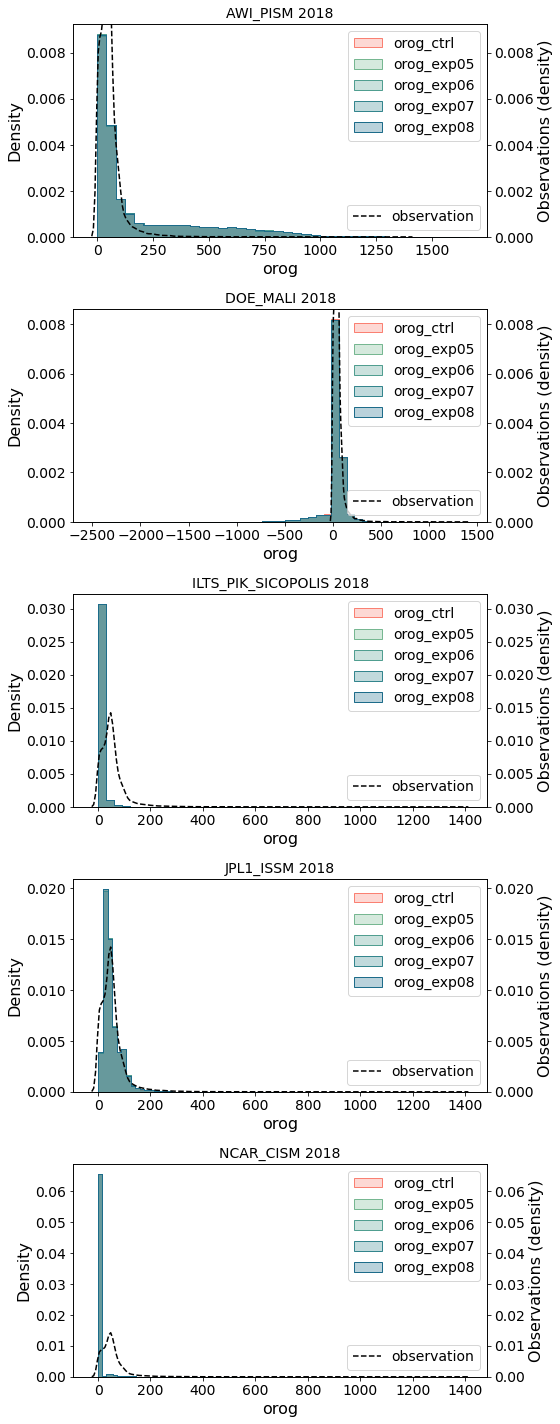

In [ ]:
''' --- Get Observational dataArray, clipped to ice shelves ------------'''
var_obs  = data_obs_ds.rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)
# Select single year ;  Stack samples to 1D 
var_obs_stack_da = var_obs.isel(time=0).stack(samples=['x','y']).dropna(dim='samples',how='all')[varname_obs] # select one year

print('MINMAX of observational data (excl gruonded): {:.3f} - {:.3f}'.format( 
    var_obs[varname_obs].min().values, var_obs[varname_obs].max().values)
)

minmax_obs = [var_obs[varname_obs].min().values, var_obs[varname_obs].max().values ]
df_minmax = pd.DataFrame( {'min':minmax_obs[0], 'max':minmax_obs[1]}, index=[varname_obs])


''' --- Plot model experiments data-distribution for select year ------------'''
yidx = 3 # select single year

fig,axs=plt.subplots(5,1,figsize=(8,20))
exp_var_list = list(data_ismip_ds_list[0].data_vars )

for idx , var_ds in enumerate(data_ismip_ds_list):
    # print(idx)  
    ismip_model = var_ds.attrs['model_abbrev']
    print(idx, ismip_model)
    
    ## Overwrite temporal value with the same time array for all ismip_models'''
    var_ds = var_ds.assign_coords(time=years) # annual values
    
    ## Clip to mask (e.g. Grounding line)
    var_ds  = var_ds.rio.clip( groundingLine_gpd.geometry, groundingLine_gpd.crs, drop=False, invert=True)

    ## CALCULATE RANGE
    minmax = [var_ds.to_array('tmp').min().values, var_ds.to_array('tmp').max().values ]
    df_minmax = pd.concat([ df_minmax, 
                        pd.DataFrame( {'min':minmax[0], 'max':minmax[1]}, index=[ismip_model])
                        ] )
    print('MINMAX of model data (excl grounded ice ): {:.3f} - {:.3f}'.format( 
        minmax[0], minmax[1] #var_ds.min().values, var_ds.max().values)
    ))
    
    ## calculate how often values are exceeded
    ## ... to do 

    ## Select single year
    ## Stack samples to 1D 
    var_ds_stack = var_ds.isel(time=yidx).stack(samples=['x','y']) # select one year
    
    # # moving window average
    # # da_plot = da_plot.rolling(time=5).mean()

    ax = axs[idx]
    ax.set_prop_cycle( cycler(color=my_palette2) )

    ## Drop nan
    var_ds_stack = var_ds_stack.dropna(dim='samples',how='all') # 

    for i, exp_num in enumerate(list(var_ds_stack.data_vars)):
        da_plot = var_ds_stack[exp_num]
        sns.histplot( da_plot,ax=ax, 
                        bins=40, element='step', alpha=0.3,
                        color=my_palette2[i], 
                        stat='density',
                        ) #, x='variable')#, hue='time')    

    # add kde of observations
    ax2 = ax.twinx()
    sns.kdeplot( var_obs_stack_da ,ax=ax2, linestyle='--',  color='black') # 'forestgreen',) 
    ax2.set_ylabel('Observations (density)'); ax2.legend(['observation'],loc='lower right')
    ax2.set_ylim(ax.get_ylim()) # set rigth axis to same ylim as left axis (only if plotting both Density histograms)

    ax.set_title(ismip_model + ' '+ str(years[yidx]) )
    ax.legend(exp_var_list ) # update names in legend
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    ax.set_xlabel(varname)
fig.tight_layout()

df_minmax
## save fig
# figname = varname + '_' + 'ismipModels' + '_data_distrib.png'
# fig.savefig(os.path.join(homedir,'Data/ISMIP6/figures/aggregated_iceshelves/',figname), bbox_inches='tight')

## save DataRange info
# df_minmax